### The ageing stopping network: An examination of regional and network changes in the IFG, preSMA, and STN across the lifespan 

    Code written by:    Sarah Kemp 
                        sarahannekemp@gmail.com
                        October 2023 
                    
In this paper, we collected two datasets, one being a high quality diffusion dataset acquired at 3T, and the other a qMRI acquired at 7T (ultra-high field). We had a fairly large sample of people aged 18-80, and have assessed the anatomical and network changes in the stopping network in a number of different ways. 

This notebook does a series of analysis steps: 

    1 {DATA WRANGLING}
        > rearranging dfs as necessary

    2 {COLLAPSE HEMISPHERES}
        > t-test to see if the hems are different + then collapse them for better power 

    3 {POLYNOMIAL REGRESSIONS}
        > fit a bunch of regressions for each region and tract of interest 
        > of the winning models, remove the influential datapoints using cook's distance 
        > redo model comparison with these datapoints removed 

    4 {MEDIATION}
        > further quantify the relationship between age and the diffusion variables w a mediation analysis 
        
        

# {0} SETUP

In [1]:
from collections import defaultdict
from datetime import datetime
from itertools import combinations
import math
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd
from scipy.stats import shapiro
from scipy import stats
import seaborn as sns
from sklearn.metrics import r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.mediation import Mediation
from statsmodels.stats.mediation import MediationResults

import warnings

In [2]:
##############################
##
## SET DIRECTORIES AND LOAD FILES
##
##############################


## Main directory ##
workdir = 'C:/Users/sarah/OneDrive - University of Tasmania/projects/ahead/data/tux11'


## Quantitative ROI file ##
# File with myelin and iron for each region [left and right preSMA, IFG, STN]
q_roi = pd.read_csv(workdir+'/Dwi/qmri_roi_values.csv')


## Quantitative tract file ##
# File with tmyelin and iron for each tract [left and right STN-IFG, STN-preSMA, and preSMA-IFG]
q_tract = pd.read_csv(workdir+'/Dwi/qmri_values.csv')

## Diffusion file ##
# File with the FA and ADC values (for each tract) 
dwi = pd.read_csv(workdir+'/Dwi/updated_diffusion_values.csv')

## age file ## 
agedf = pd.read_csv(workdir+'/Demographics/StoppingAge-DWI-AHEAD-Demographics-ALL-DWI.csv')


# save results to this folder 
resultsdir = 'C:/Users/sarah/OneDrive - University of Tasmania/projects/ahead/results'

# {1} DATA WRANGLING

In [3]:
# The quantitative files (saved as q_roi) have the ROIs and hemispheres listed in individual columns 
# Add a new column with both bits of information so the columns are consistent between the three CSVs

def combineROIhemisphere(row):
    if 'left' in row['hemisphere']: 
        if 'preSMA' in row['ROI']: 
            return 'left preSMA'
        elif 'IFG' in row['ROI']:
            return 'left IFG'
        elif 'STN' in row['ROI']: 
            return 'left STN'
        else:
            return 'left ROI ERROR'
    elif 'right' in row['hemisphere']:
        if 'preSMA' in row['ROI']: 
            return 'right preSMA'
        elif 'IFG' in row['ROI']:
            return 'right IFG'
        elif 'STN' in row['ROI']: 
            return 'right STN'
        else: 
            return 'right ROI error'
    else: 
        return 'hemisphere error'
        
q_roi['region'] = q_roi.apply(combineROIhemisphere, axis=1)



# rename the columns iron_value, myelin_value, fa_value, and md_value because it's annoying to write _value all the time
q_roi = q_roi.rename(columns={'iron_value': 'iron', 'myelin_value': 'myelin'})
q_tract = q_tract.rename(columns={'iron_value': 'iron', 'myelin_value': 'myelin'})
dwi = dwi.rename(columns={'fa_value': 'fa', 'md_value': 'md'})    

# {2} COLLAPSE HEMISPHERES


C:\Users\sarah\miniconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\sarah\miniconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\sarah\miniconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\sarah\miniconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

Text(0.5, 9.444444444444438, 'ADC')

<Figure size 1200x800 with 0 Axes>

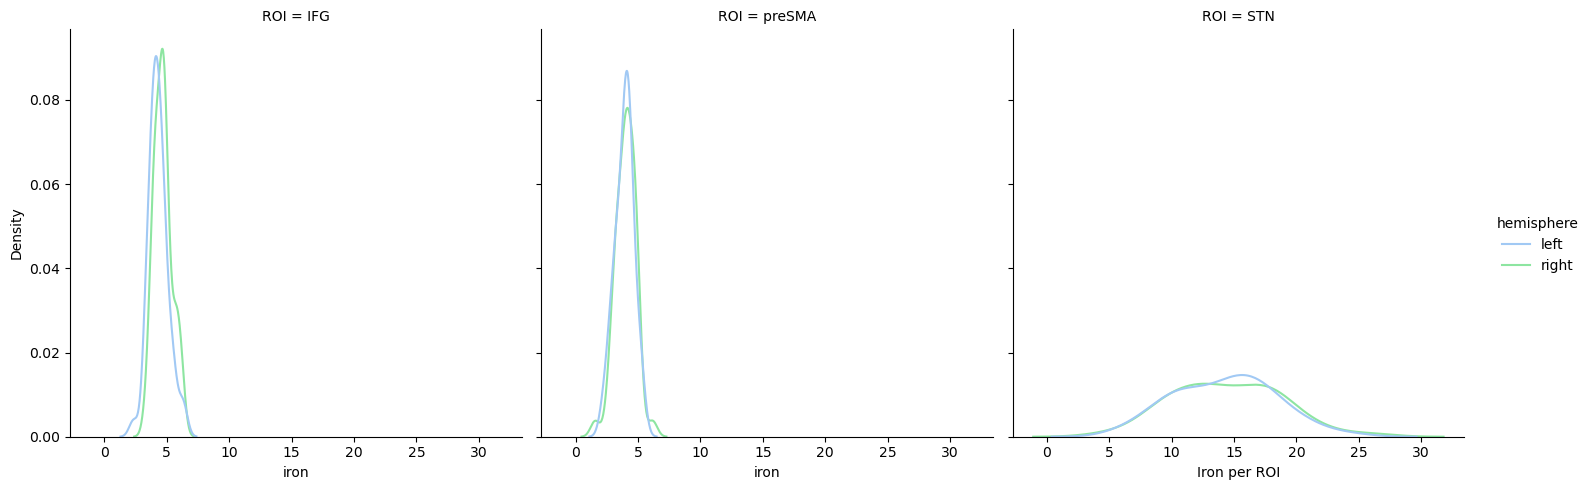

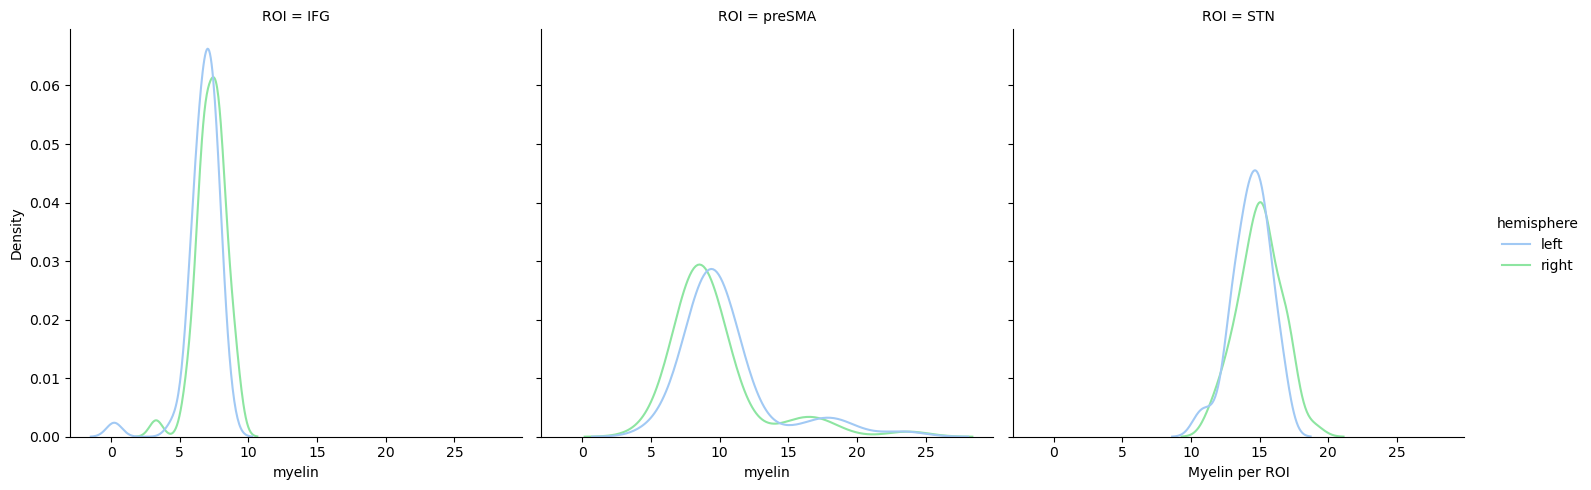

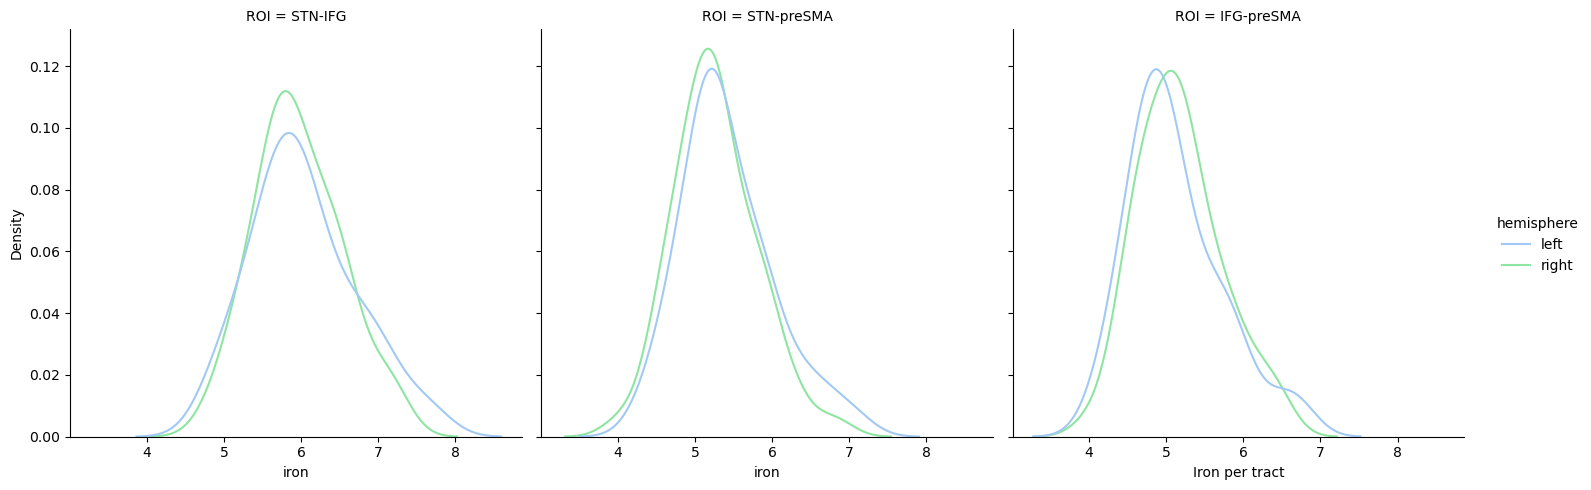

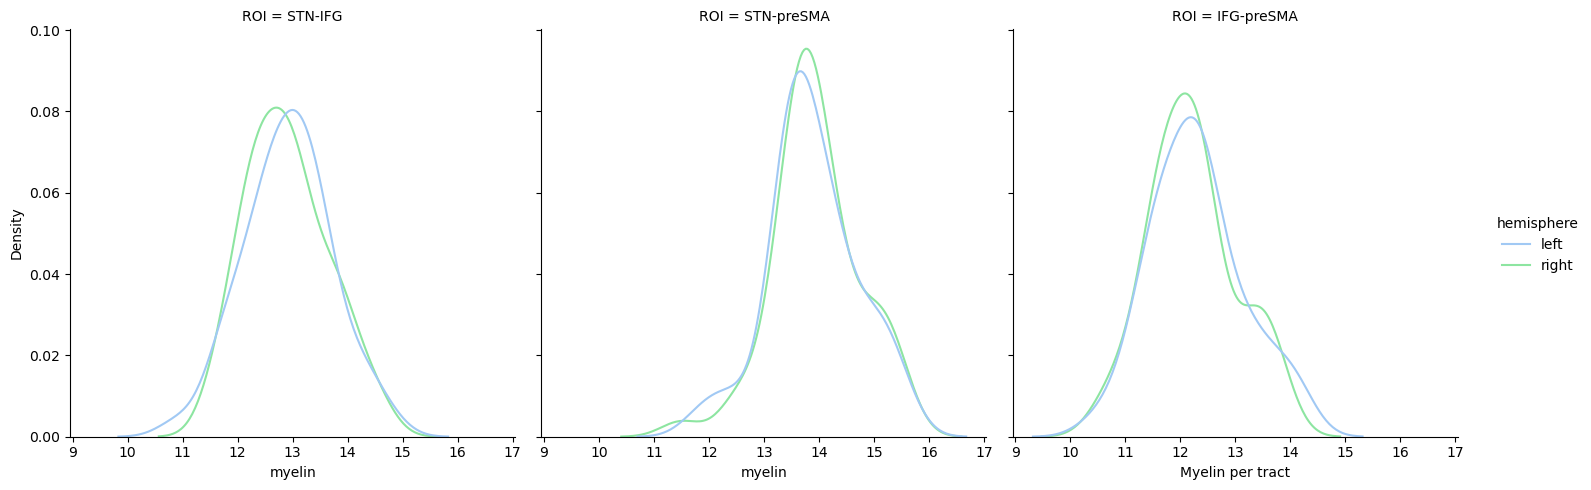

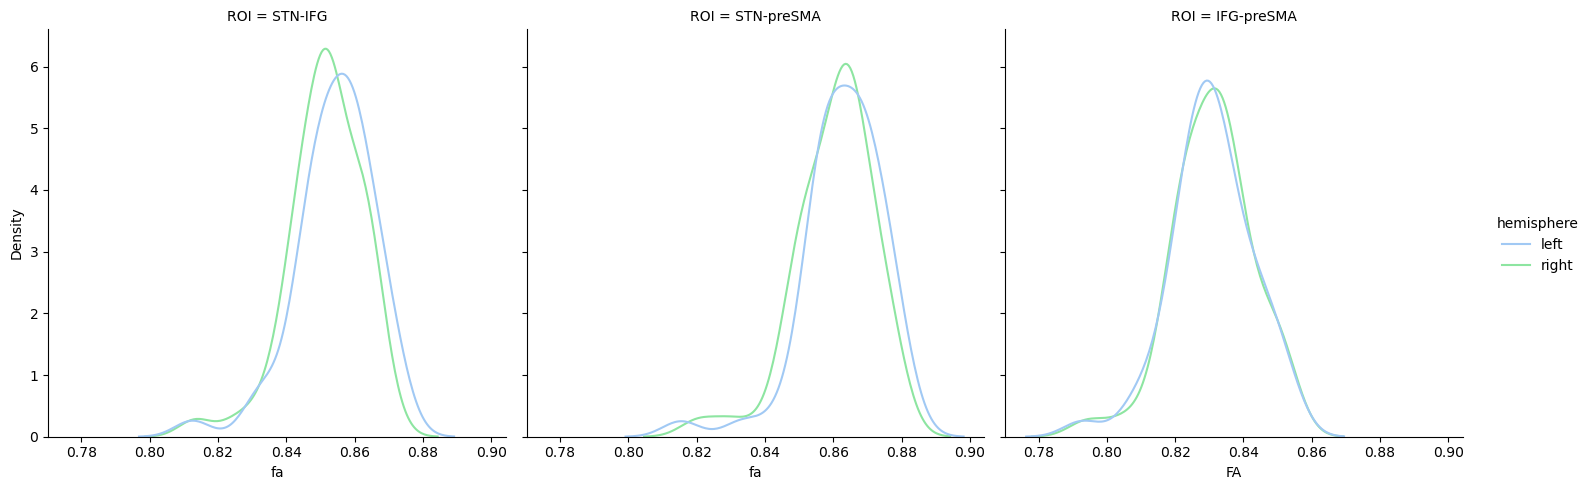

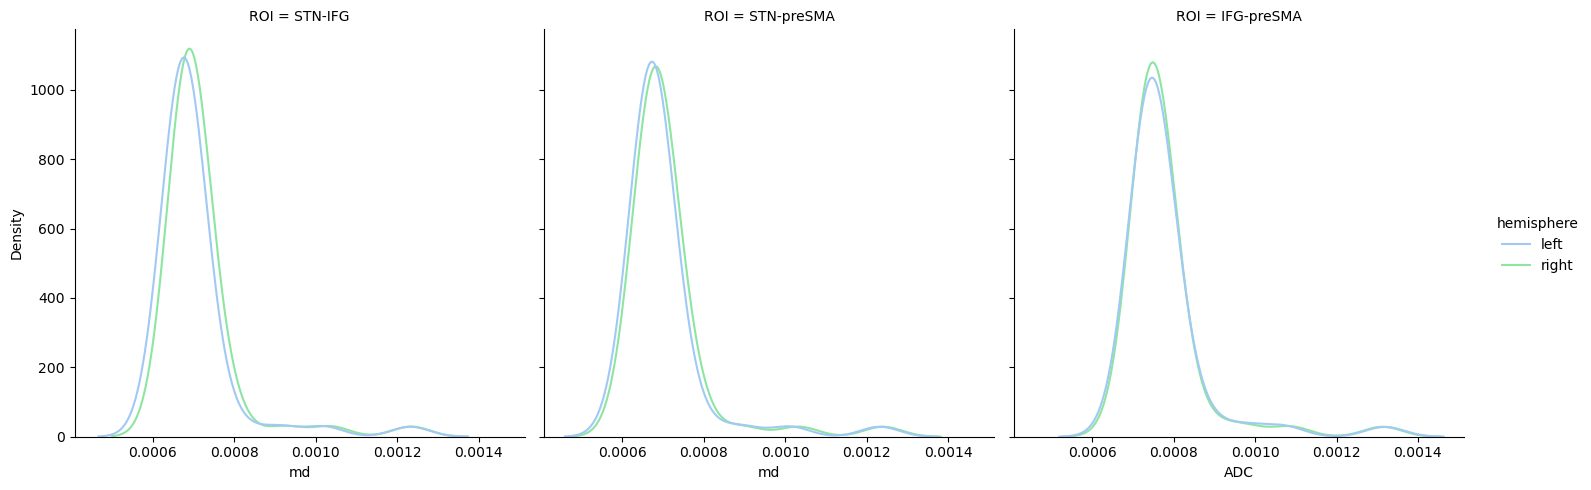

In [4]:

##
## Visualise the distributions 
## 


sns.set_palette("pastel6")

plt.figure(figsize=(12, 8))

# qmri: iron 
sns.displot(q_roi, x='iron', hue='hemisphere', kind='kde', col='ROI')
plt.xlabel("Iron per ROI")
#plt.title('Distribution of iron per region')

# qmri: myelin 
sns.displot(q_roi, x='myelin', hue='hemisphere', kind='kde', col='ROI')
plt.xlabel("Myelin per ROI")
#plt.title('Distribution of myelin per region')

sns.displot(q_tract, x='iron', hue='hemisphere', kind='kde', col='ROI')
plt.xlabel("Iron per tract")
#plt.title('Distribution of iron per tract')

sns.displot(q_tract, x='myelin', hue='hemisphere', kind='kde', col='ROI')
plt.xlabel("Myelin per tract")
#plt.title('Distribution of myelin per tract')

# dwi: fractional anisotropy 
sns.displot(dwi, x='fa', hue='hemisphere', kind='kde', col='ROI')
plt.xlabel("FA")
#plt.title('Distribution of FA per tract')

# dwi: adc 
sns.displot(dwi, x='md', hue='hemisphere', kind='kde', col='ROI')
plt.xlabel("ADC")
#plt.title('Distribution of ADC per tract')

In [5]:
##
## T TESTS 
## 
## Indepdent samples t-test on each of the DVs 



quantitative_dfs = [q_roi, q_tract]


# iron and myelin values 
for df in quantitative_dfs:
    t, p = stats.ttest_ind(df[df['hemisphere'] == 'left']['iron'], 
                           df[df['hemisphere'] == 'right']['iron'])
    print('iron t = ', str(round(t, 2)), ' p = ', str(round(p, 4)))

    t, p = stats.ttest_ind(df[df['hemisphere'] == 'left']['myelin'], 
                           df[df['hemisphere'] == 'right']['myelin'])
    print('myelin t = ', str(round(t, 2)), ' p = ', str(round(p, 4)))


# diffusion values  
t, p = stats.ttest_ind(dwi[dwi['hemisphere'] == 'left']['fa'],
                       dwi[dwi['hemisphere'] == 'right']['fa'])
print('FA: t = ', str(round(t, 2)), ' p = ', str(round(p, 4)))

# adc 
t, p = stats.ttest_ind(dwi[dwi['hemisphere'] == 'left']['md'],
                       dwi[dwi['hemisphere'] == 'right']['md'])
print('MD: t = ', str(round(t, 2)), ' p = ', str(round(p, 4)))


iron t =  -0.35  p =  0.73
myelin t =  -0.21  p =  0.832
iron t =  0.69  p =  0.4927
myelin t =  0.13  p =  0.8967
FA: t =  0.83  p =  0.4075
MD: t =  -0.69  p =  0.4935


In [6]:
## None of the t tests are significant, so we will collapse across the two hemispheres to keep the analysis simpler 

## Take the mean of the DVs for each unique subect and region combination (groupby identifies the combinations and .agg 
## averages them)


# quantitative regions (stn, preSMA, ifg)
collapse_qroi = q_roi.groupby(["subjectID", "ROI"]) 
collapse_qroi = collapse_qroi.agg({'iron': 'mean', 'myelin': 'mean'}).reset_index()

# quantitative tract  
collapse_qtract = q_tract.groupby(["subjectID", "ROI"])
collapse_qtract = collapse_qtract.agg({'iron': 'mean', 'myelin': 'mean'}).reset_index()

# diffusion values
collapse_dwi = dwi.groupby(["subjectID", "ROI"])
collapse_dwi = collapse_dwi.agg({'fa': 'mean', 'md': 'mean'}).reset_index()


# {3} POLYNOMIAL REGRESSIONS

First some data crunching: age isn't in these dataframes yet, so need to get the participants' ages and add that column to each 
of the dataframes. 



In [7]:
############

### ADD THE AGES 

#########


def scan_to_subjectID(scan_code):
    scan_code = scan_code.split('_')[1]
    return "sub-" + scan_code[1:]

agedf = agedf.assign(subjectID=agedf.Scan_Code.apply(scan_to_subjectID))

dfs = [collapse_dwi, collapse_qroi, collapse_qtract]

for df in dfs:

    ages = []
    for row in df.itertuples():
        # get the respective row in age_df
        row_in_age = agedf.loc[agedf.subjectID==row.subjectID]

        # check if we get a result
        if len(row_in_age) < 1:
            print('Could not find a record with this id')
            ages.append(pd.NA)

        else:
            # retrieve the dates we need
            date_of_birth = row_in_age['DateOfBirth'].iloc[0]
            test_date = row_in_age['DateOfScan-R03'].iloc[0]

            # transform them into date objects so we can do math with them
            dob_obj = datetime.strptime(date_of_birth, '%d/%m/%Y')
            td_obj = datetime.strptime(test_date, '%d/%m/%Y')

            # divide the number of days by 365.25 to approximate years
            age = (td_obj-dob_obj).days/365.25
            # and append the rounded down number 
            ages.append(math.floor(age))
    df['age'] = ages
      


In [8]:
###############

# ADD POLYNOMIAL TERMS 

##############


pd.set_option('chained_assignment',None)

# give the dfs a better name 
dwi = collapse_dwi
qroi = collapse_qroi
qtract = collapse_qtract

dfs = [dwi, qroi, qtract]

    
qroi.to_csv(workdir+'/Dwi/collapsed_qroi.csv', index=False)
qtract.to_csv(workdir+'/Dwi/collapsed_qtract.csv', index=False)
dwi.to_csv(workdir+'/Dwi/collapsed_dwi.csv', index=False) 


In [9]:
## make individual dataframes  (since we run the regressions on each tract/region individually)


##### regions #####
ifg_roi = qroi[qroi['ROI'] == 'IFG']
pre_roi = qroi[qroi['ROI'] == 'preSMA']
stn_roi = qroi[qroi['ROI'] == 'STN']

##### tracts #####

# IFG-preSMA
q_ifg_pre = qtract[qtract['ROI'] == 'IFG-preSMA']
dwi_ifg_pre = dwi[dwi['ROI'] == 'IFG-preSMA']

# STN-IFG
q_stn_ifg = qtract[qtract['ROI'] == 'STN-IFG']
dwi_stn_ifg = dwi[dwi['ROI'] == 'STN-IFG']

# STN-preSMA 
q_stn_pre = qtract[qtract['ROI'] == 'STN-preSMA']
dwi_stn_pre = dwi[dwi['ROI'] == 'STN-preSMA']


Note: At this point, i previously standardised all predictors, making the mean 0 and the SD 1. 
This was done because when I originally started running the models, I was getting warnings regarding high condition numbers due to the differences in scaling between the different variables. However this became quite a headache later in terms of drawing figures and interpreting the models, so I went back and found that the standardised and non-standardised models didn't really differ in terms of model fit or anything else. Proceeded with non-standardised models. 


Now generate the models. For each of the outcomes (regional iron, regional myelin, tract iron, tract myelin, tract FA, tract
MD), I generated 3 possible regression models:  

* Model 1 = DV ~ Age 
* Model 2 = DV ~ Age + Age^2
* Model 3 = DV ~ Age + Age^2 + Age^3

The BIC values of each of the three models are compared, and then the model with the lowest one becomes the winning model. 
Two CSV files are written here, one called **model_comparison** that has this information for every model: 

* measure (iron, myelin, etc) 
* AIC
* BIC
* intercept
* age coefficient (the linear term) 
* age^2 coefficient (the quadratic term) 
* R-squared
* p-value


& all the winning models are saved to a file called **winning_models** 


In [10]:
# square the terms in the formula or it screws up (don't square them first)

formulas = ['age', 
            'age + I(age ** 2)', 
            'age + I(age ** 2) + I(age ** 3)']


dfs = {'ifg': ifg_roi, 'presma': pre_roi, 'stn': stn_roi,
       'q-ifg-pre': q_ifg_pre, 'q-stn-ifg': q_stn_ifg, 'q-stn-pre': q_stn_pre,
       'dwi-ifg-pre': dwi_ifg_pre, 'dwi-stn-ifg': dwi_stn_ifg, 'dwi-stn-pre': dwi_stn_pre}


def create_model_info(df, dv, formula):
    model = smf.ols(f'{dv} ~ {formula}', data=df).fit()
    
    model_info = {'measure': dv, 'region': df_name, 'model': formula, 'AIC': model.aic,
                  'BIC': model.bic, 'R-squared': model.rsquared, 'p-value': model.f_pvalue,
                  'F': model.fvalue, 'df-model': model.df_model, 'df-residuals': model.df_resid,
                  'intercept': model.params['Intercept']}
    
    for predictor in ['age', 'I(age ** 2)', 'I(age ** 3)']:
        if predictor in model.params.index:
            if '3' in predictor: 
                term = 'age3'
            elif '2' in predictor: 
                term = 'age2'
            else: 
                term = 'age'
            #term = predictor.split('_')[0]
            model_info[f'{term}-coefficient'] = model.params[predictor]

    return model_info

warnings.filterwarnings("ignore", category=FutureWarning)

model_comparison = pd.DataFrame(columns=['measure', 'region', 'model',
                                         'AIC', 'BIC', 'R-squared', 'p-value', 'F', 'df-model', 'df-residuals',
                                         'intercept', 'age-coefficient', 'age2-coefficient', 'age3-coefficient'])



for df_name, df in dfs.items():
    if 'iron' in df.columns.tolist():
        dv_list = ['iron', 'myelin']
    elif 'fa' in df.columns.tolist():
        dv_list = ['fa', 'md']
    else:
        print(f"Can't work out the outcome variables for {df_name}")
        continue

    for dv in dv_list:
        for formula in formulas:
            model_info = create_model_info(df, dv, formula)
            # Convert dictionary to df and concat - was using pd append but this is deprecated 
            model_comparison = pd.concat([model_comparison, pd.DataFrame([model_info])], ignore_index=True)


# Find the winning models
find_winners = model_comparison.groupby(['measure', 'region'])['BIC'].idxmin()
part1_winningmodels = model_comparison.loc[find_winners]

# Save the CSVs
part1_winningmodels.to_csv(resultsdir + '/regressions_winningmodels_with_outliers.csv', index=False)
model_comparison.to_csv(resultsdir + '/regressions_allmodels_with_outliers.csv', index=False)



# now need to reassess each variable in all of the winning models for outliers according to cook's distance
# and then from there redo the model comparisons


In [11]:
## now look through that winning_models_test and remove outliers for each variable 
dfs = {'ifg': ifg_roi, 'presma': pre_roi, 'stn': stn_roi,
       'q-ifg-pre': q_ifg_pre, 'q-stn-ifg': q_stn_ifg, 'q-stn-pre': q_stn_pre,
       'dwi-ifg-pre': dwi_ifg_pre, 'dwi-stn-ifg': dwi_stn_ifg, 'dwi-stn-pre': dwi_stn_pre}

# formulas = ['age_cen', 
#             'age_cen + age2_cen', 
#             'age_cen + age2_cen + age3_cen']

formulas = ['age', 
            'age + I(age ** 2)', 
            'age + I(age ** 2) + I(age ** 3)']

model_comparison = pd.DataFrame(columns=['measure', 'region', 'model',
                                         'AIC', 'BIC', 'R-squared', 'p-value', 'F', 'df-model', 'df-residuals',
                                         'intercept', 'age-coefficient', 'age2-coefficient', 'age3-coefficient'])

removed_rows = pd.DataFrame(columns = ['df', 'removed_rows'])


for row in part1_winningmodels.itertuples():

    # identify the right df
    if row.region == 'dwi-ifg-pre':
        df = dwi_ifg_pre
    elif row.region == 'dwi-stn-ifg':
        df = dwi_stn_ifg 
    elif row.region == 'dwi-stn-pre':
        df = dwi_stn_pre
    elif row.region == 'q-ifg-pre':
        df = q_ifg_pre
    elif row.region == 'q-stn-ifg':
        df = q_stn_ifg
    elif row.region == 'q-stn-pre':
        df = q_stn_pre
    elif row.region == 'ifg':
        df = ifg_roi
    elif row.region == 'presma':
        df = pre_roi
    elif row.region == 'stn':
        df = stn_roi
    else:
        print('can\'t find a dataframe for ', row.region)
        
    # now check for outliers within that dataframe - make each model and check for cook's distance     
    print('checking for outliers in ', row.region, ':', row.measure, '~', row.model)
    
    formula = f'{row.measure} ~ {row.model}'
    model = smf.ols(formula, data = df).fit()
    influence = model.get_influence()
    cooks = influence.cooks_distance
    cooks_values = cooks[0] #two arrays - only want the first which has the actual values (second array is p values)
    removed_indices = []

    for i, cook_value in enumerate(cooks_values):
        if cook_value > 4 / len(df):
            print(f'Removing row {i} due to high Cook\'s distance: {cook_value}')
            removed_indices.append(i)

    print(removed_indices)
    
    # Remove rows identified to have high Cook's distance
    if removed_indices:
        #fix_name = row.region.replace('-', '_')
        #new_variable_name = f'cooks_{fix_name}'
        df = df.drop(df.index[removed_indices])
                         
        print(f'{len(removed_indices)} rows removed from ', row.region)
        
    # now save that dfs output 
    df.to_csv(f"{workdir}/Dwi/cook_distance_removed/{row.region}.csv", index=False)


    





checking for outliers in  dwi-ifg-pre : fa ~ age
Removing row 0 due to high Cook's distance: 0.26092520406897707
Removing row 38 due to high Cook's distance: 0.08879273690087319
[0, 38]
2 rows removed from  dwi-ifg-pre
checking for outliers in  dwi-stn-ifg : fa ~ age
Removing row 0 due to high Cook's distance: 0.3450560299464827
Removing row 19 due to high Cook's distance: 0.08260200087615774
[0, 19]
2 rows removed from  dwi-stn-ifg
checking for outliers in  dwi-stn-pre : fa ~ age
Removing row 0 due to high Cook's distance: 0.36733250021799874
Removing row 19 due to high Cook's distance: 0.08882776721862289
Removing row 45 due to high Cook's distance: 0.08425606270160876
[0, 19, 45]
3 rows removed from  dwi-stn-pre
checking for outliers in  ifg : iron ~ age + I(age ** 2)
Removing row 3 due to high Cook's distance: 0.09279981318527271
Removing row 32 due to high Cook's distance: 0.08246890729961434
[3, 32]
2 rows removed from  ifg
checking for outliers in  presma : iron ~ age
Removing r

In [12]:
# now recheck all the models with the high cook's distance values removed 

# rewriting the formulas unnecessarily so i can remember what the hell i'm doing 

formulas = ['age', 
            'age + I(age ** 2)', 
            'age + I(age ** 2) + I(age ** 3)']


def create_model_info(df, dv, formula):
    model = smf.ols(f'{dv} ~ {formula}', data=df).fit()
    
    model_info = {'measure': dv, 'region': regionname, 'model': formula, 'AIC': model.aic,
                  'BIC': model.bic, 'R-squared': model.rsquared, 'p-value': model.f_pvalue,
                  'F': model.fvalue, 'df-model': model.df_model, 'df-residuals': model.df_resid,
                  'intercept': model.params['Intercept']}
    
    for predictor in ['age', 'I(age ** 2)', 'I(age ** 3)']:            
        if predictor in model.params.index:
            if '3' in predictor: 
                term = 'age3'
            elif '2' in predictor: 
                term = 'age2'
            else: 
                term = 'age'
            #term = predictor.split('_')[0]
            model_info[f'{term}-coefficient'] = model.params[predictor]

    return model_info

warnings.filterwarnings("ignore", category=FutureWarning)

model_comparison = pd.DataFrame(columns=['measure', 'region', 'model',
                                         'AIC', 'BIC', 'R-squared', 'p-value', 'F', 'df-model', 'df-residuals',
                                         'intercept', 'age-coefficient', 'age2-coefficient', 'age3-coefficient'])

# look for all the CSVs we just saved 

for csv in os.listdir(workdir + '/Dwi/cook_distance_removed/'):
    df = pd.read_csv(os.path.join(workdir + '/Dwi/cook_distance_removed/', csv))
    regionname = csv.split(".")[0]
    # print(csv)
    # print(regionname)
    
    # check what kind of measures we have 
    if 'iron' in df.columns: 
        dvs = ['iron', 'myelin']
    elif 'fa' in df.columns: 
        dvs = ['fa', 'md']
    else: 
        print('can\'t find the right DVs')
   # print(dvs)
    
    # now cycle through and make your formulas 
    
    for dv in dvs:
        for formula in formulas:
           # print(dv, formula)
            model_info = create_model_info(df, dv, formula)
           # model_comparison = model_comparison.append(model_info, ignore_index=True)  # old code - pre pandas update
            model_comparison = pd.concat([model_comparison, pd.DataFrame([model_info])], ignore_index=True)

# Find the winning models
find_winners = model_comparison.groupby(['measure', 'region'])['BIC'].idxmin()
part1_winningmodels_cooks = model_comparison.loc[find_winners]

# Save the CSVs
part1_winningmodels_cooks.to_csv(resultsdir + '/regressions_winningmodels_cooks_removed.csv', index=False)
model_comparison.to_csv(resultsdir + '/regressions_allmodels_cooks_removed.csv', index=False)

print('done')
    

done


In [13]:
# remove the oldest person 


formulas = ['age', 
            'age + I(age ** 2)', 
            'age + I(age ** 2) + I(age ** 3)']


def create_model_info(df, dv, formula):
    model = smf.ols(f'{dv} ~ {formula}', data=df).fit()
    
    model_info = {'measure': dv, 'region': regionname, 'model': formula, 'AIC': model.aic,
                  'BIC': model.bic, 'R-squared': model.rsquared, 'p-value': model.f_pvalue,
                  'F': model.fvalue, 'df-model': model.df_model, 'df-residuals': model.df_resid,
                  'intercept': model.params['Intercept']}
    
    
    for predictor in ['age', 'I(age ** 2)', 'I(age ** 3)']:            
        if predictor in model.params.index:
            if '3' in predictor: 
                term = 'age3'
            elif '2' in predictor: 
                term = 'age2'
            else: 
                term = 'age'
            #term = predictor.split('_')[0]
            model_info[f'{term}-coefficient'] = model.params[predictor]
            
            
    return model_info

warnings.filterwarnings("ignore", category=FutureWarning)

model_comparison = pd.DataFrame(columns=['measure', 'region', 'model',
                                         'AIC', 'BIC', 'R-squared', 'p-value', 'F', 'df-model', 'df-residuals',
                                         'intercept', 'age-coefficient', 'age2-coefficient', 'age3-coefficient'])

# look for all the CSVs we just saved 

for csv in os.listdir(workdir + '/Dwi/cook_distance_removed/'):
    df = pd.read_csv(os.path.join(workdir + '/Dwi/cook_distance_removed/', csv))
    df = df[df['age'] < 80]
    regionname = csv.split(".")[0]
   # print(csv)
   # print(regionname)
    
    # check what kind of measures we have 
    if 'iron' in df.columns: 
        dvs = ['iron', 'myelin']
    elif 'fa' in df.columns: 
        dvs = ['fa', 'md']
    else: 
        print('can\'t find the right DVs')
    #print(dvs)
    
    # now cycle through and make your formulas 
    
    for dv in dvs:
        for formula in formulas:
            #print(dv, formula)
            model_info = create_model_info(df, dv, formula)
            #model_comparison = model_comparison.append(model_info, ignore_index=True) # old code from pre pd update
            model_comparison = pd.concat([model_comparison, pd.DataFrame([model_info])], ignore_index=True)

# Find the winning models
find_winners = model_comparison.groupby(['measure', 'region'])['BIC'].idxmin()
part1_winningmodels_cooks = model_comparison.loc[find_winners]

# Save the load

part1_winningmodels_cooks.to_csv(resultsdir + '/regressions_winningmodels_cooks_oldest_removed.csv', index=False)
model_comparison.to_csv(resultsdir + '/regressions_allmodels_cooks_oldest_removed.csv', index=False)

print('oldest person removed & models resaved')
    

oldest person removed & models resaved


# {4} MEDIATION
Mediation analysis for each tract of interest to see if myelin or iron are mediators for the age > diffusion relationship

In [18]:
# load dfs 

mediationdir = workdir + '/Dwi/cook_distance_removed/combined_dfs_mediation_analysis/'

ifg_pre = pd.read_csv(mediationdir + 'ifg-pre.csv')
stn_ifg = pd.read_csv(mediationdir + 'stn-ifg.csv')
stn_pre = pd.read_csv(mediationdir + 'stn-pre.csv')


dfs = {'ifg_pre': ifg_pre, 'stn_ifg': stn_ifg, 'stn_pre': stn_pre}

for df_name, df in dfs.items():

    print('    *************   MEDIATION FOR ', df_name, '    *************   ')
    # age > iron > fa [AIF] model 1
    # age > myelin > fa [AMF] model 2
    # age > iron > adc [AIA] model 3
    # age > myelin > adc [AMA] model 4
    
    # mediator model 
    # regression model for the mediator variable. predictor variables include the treatment/exposure and any other variables of interest
    # ie the original model. only need 2 of these since there are only 2 options for c' 
    mediator_fa = sm.OLS.from_formula('fa ~ age', data = df) 
    mediator_adc = sm.OLS.from_formula('md ~ age', data = df)
    
    # outcome model 
    # regression model for the outcome. predictor variables include the treatment/expsire, the mediator, and anything else 
    # so this has everything 
    aif = sm.OLS.from_formula('fa ~ age + iron', data = df)
    amf = sm.OLS.from_formula('fa ~ age + myelin', data = df)
    aia = sm.OLS.from_formula('md ~ age + iron', data = df)
    ama = sm.OLS.from_formula('md ~ age + myelin', data = df)
    
    # mediation models
    model1 = Mediation(aif, mediator_fa, 'age', 'iron')
    model2 = Mediation(amf, mediator_fa, 'age', 'myelin')
    model3 = Mediation(aia, mediator_adc, 'age', 'iron')
    model4 = Mediation(ama, mediator_adc, 'age', 'myelin')
    
    results_m1 = model1.fit(n_rep=1000)
    results_m2 = model2.fit(n_rep=1000)
    results_m3 = model3.fit(n_rep=1000)
    results_m4 = model4.fit(n_rep=1000)
    
    print('AGE > IRON > FA:\n')
    print(results_m1.summary(),'\n')
    
    print('AGE > MYELIN > FA:\n')
    print(results_m2.summary(),'\n')
    
    print('AGE > IRON > ADC:\n')
    print(results_m3.summary(),'\n')
    
    print('AGE > MYELIN > ADC:\n')
    print(results_m4.summary())
    
    print('\n \n \n \n')
    # acme - average causal mediated effect 
    # ade - average direct effect 



    *************   MEDIATION FOR  ifg_pre     *************   
AGE > IRON > FA:

                              Estimate  Lower CI bound  Upper CI bound  \
ACME (control)            1.578424e-07       -0.000025        0.000027   
ACME (treated)            1.578424e-07       -0.000025        0.000027   
ADE (control)             1.006551e-04       -0.000104        0.000292   
ADE (treated)             1.006551e-04       -0.000104        0.000292   
Total effect              1.008129e-04       -0.000106        0.000293   
Prop. mediated (control)  8.968797e-04       -0.628860        0.468722   
Prop. mediated (treated)  8.968797e-04       -0.628860        0.468722   
ACME (average)            1.578424e-07       -0.000025        0.000027   
ADE (average)             1.006551e-04       -0.000104        0.000292   
Prop. mediated (average)  8.968797e-04       -0.628860        0.468722   

                          P-value  
ACME (control)              0.998  
ACME (treated)              0.9